Link to article explainig code:
<url>https://cnvrg.io/pytorch-lstm/</url>

In [7]:
# imports
import torch as torch
import torch.nn as nn
from torch.autograd import Variable 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# read data
df = pd.read_csv('../../data/yearly_data.csv', index_col='date')
# drop first few rows which contain metadata
df.drop(df.index[0:4], axis=0, inplace=True)
# only use first 6 columns as data
df.drop(df.columns[np.r_[0, 7:len(df.columns)]], axis=1, inplace=True)
# convert to numeric and use zeros for NaNs
df = df.fillna(0).astype(float)
df = df.apply(pd.to_numeric)
# reverse years
df = df.reindex(index=df.index[::-1])
# turn dates into ints
df.index = df.index.astype(int, False)
# show tail
df.tail()

,fishoil_prod_peru,fishoil_prod_global,fishoil_export_peru,fishoil_export_global,fishoil_stock_peru,fishoil_consumption_global
date,,,,,,
2017,85.0,1004.0,171.0,846.0,5.0,1090.0
2018,268.0,1159.0,196.0,892.0,78.0,1078.0
2019,105.0,1078.0,184.0,954.0,0.0,1146.0
2020,169.0,1159.0,129.0,980.0,40.0,1166.0
2021,210.0,1038.0,236.0,969.0,12.0,1051.0


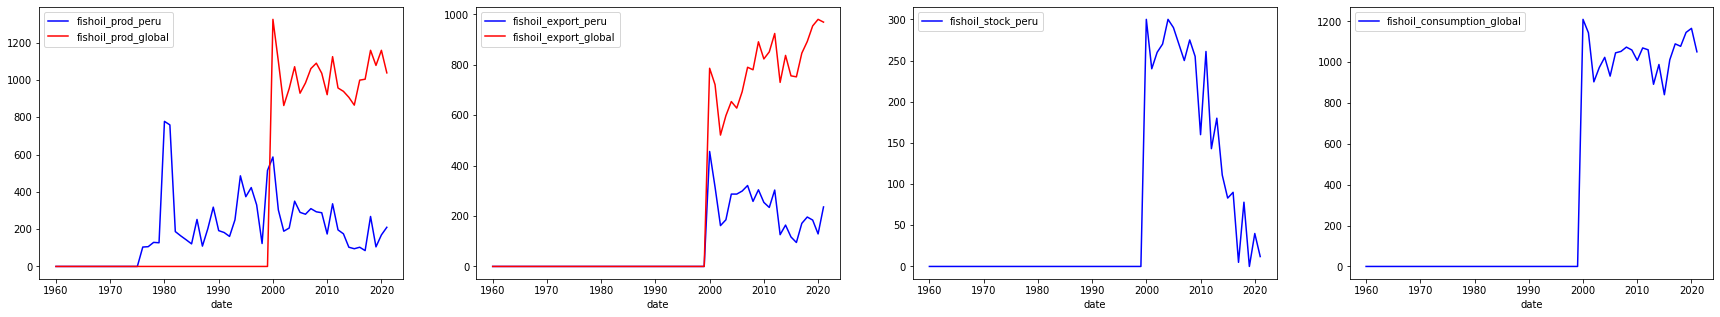

In [9]:
# plot all data
fig, axs = plt.subplots(1,4,figsize=(30, 5))

df.plot(kind='line', y='fishoil_prod_peru', color='blue', ax=axs[0])
df.plot(kind='line', y='fishoil_prod_global', color='red', ax=axs[0])

df.plot(kind='line', y='fishoil_export_peru', color='blue', ax=axs[1])
df.plot(kind='line', y='fishoil_export_global', color='red', ax=axs[1])

df.plot(kind='line', y='fishoil_stock_peru', color='blue', ax=axs[2])

df.plot(kind='line', y='fishoil_consumption_global', color='blue', ax=axs[3])
plt.show()

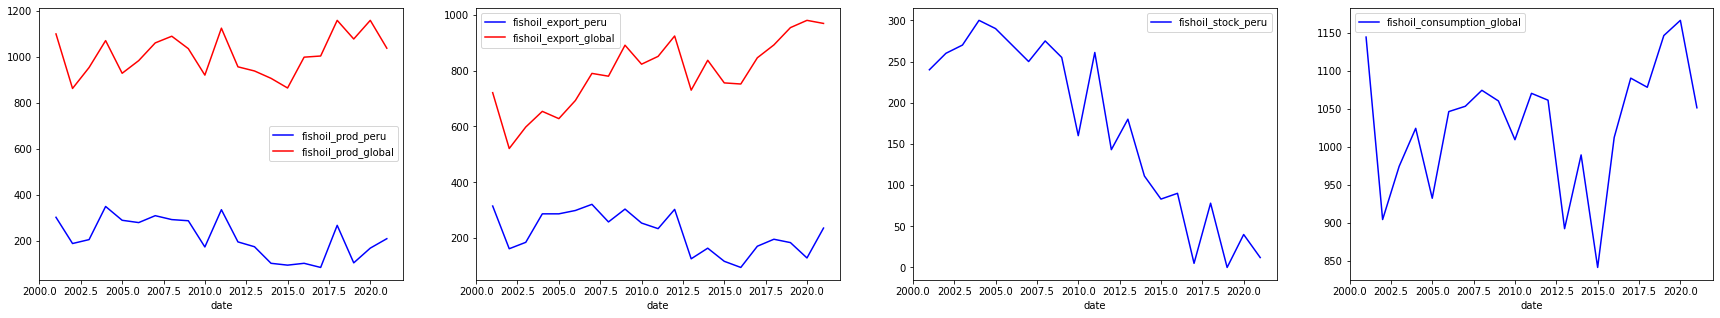

In [10]:
# plot all data past 2000
fig, axs = plt.subplots(1,4,figsize=(30, 5))

df[df.index > 2000].plot(kind='line', y='fishoil_prod_peru', color='blue', ax=axs[0])
df[df.index > 2000].plot(kind='line', y='fishoil_prod_global', color='red', ax=axs[0])

df[df.index > 2000].plot(kind='line', y='fishoil_export_peru', color='blue', ax=axs[1])
df[df.index > 2000].plot(kind='line', y='fishoil_export_global', color='red', ax=axs[1])

df[df.index > 2000].plot(kind='line', y='fishoil_stock_peru', color='blue', ax=axs[2])

df[df.index > 2000].plot(kind='line', y='fishoil_consumption_global', color='blue', ax=axs[3])
plt.show()

In [11]:
# seperate predictors from output
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6]
y.head()

# split data into train, test, and validation set (right now we don't have the price data so fishoil_consumption_global takes this place)
X_train = X.loc[1960:2010:]
X_test = X.loc[2011:2018:]
X_validate = X.loc[2019:2021:]

y_train = y.loc[1960:2010:]
y_test = y.loc[2011:2018:]
y_validate = y.loc[2019:2021:]

In [12]:
# convert data to pytorch variables
X_train_tensors = Variable(torch.Tensor(X_train.values))
X_test_tensors = Variable(torch.Tensor(X_test.values))

y_train_tensors = Variable(torch.Tensor(y_train.values))
y_test_tensors = Variable(torch.Tensor(y_test.values)) 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (51, 5) (51, 1)
Testing Shape (8, 5) (8, 1)


In [13]:
# reshape tensors to include timestamp
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([51, 1, 5]) torch.Size([51, 1])
Testing Shape torch.Size([8, 1, 5]) torch.Size([8, 1])


In [14]:
# definition of LSTM model
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes      # number of classes
        self.num_layers = num_layers        # number of layers
        self.input_size = input_size        # input size
        self.hidden_size = hidden_size      # hidden state
        self.seq_length = seq_length        # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 1
        self.fc = nn.Linear(128, num_classes) # fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # internal state
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # final Output
        return out

In [15]:
# variable definitions
num_epochs = 100            # 100 epochs
learning_rate = 0.001       # 0.001 lr

input_size = 5              # number of features
hidden_size = 2             # number of features in hidden state
num_layers = 1              # number of stacked lstm layers

num_classes = 1             # number of output classes 

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) # lstm layer

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [16]:
# train the model
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_tensors_final) # forward pass
  optimizer.zero_grad() # caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() # calculates the loss of the loss function
 
  optimizer.step() # improve from loss, i.e backprop
  if epoch % 10 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 234267.12500
Epoch: 10, loss: 234159.07812
Epoch: 20, loss: 234049.14062
Epoch: 30, loss: 233936.09375
Epoch: 40, loss: 233818.56250
Epoch: 50, loss: 233694.87500
Epoch: 60, loss: 233563.93750
Epoch: 70, loss: 233424.35938
Epoch: 80, loss: 233275.09375
Epoch: 90, loss: 233114.98438
